In [1]:
# pip install supervision
# ! pip install opencv-python
# apt-get update

# OpenCV 관련 시스템 라이브러리 설치
# apt-get install -y libgl1-mesa-glx
# !apt-get install -y libglib2.0-0

Using device: cuda


Detected 3 faces


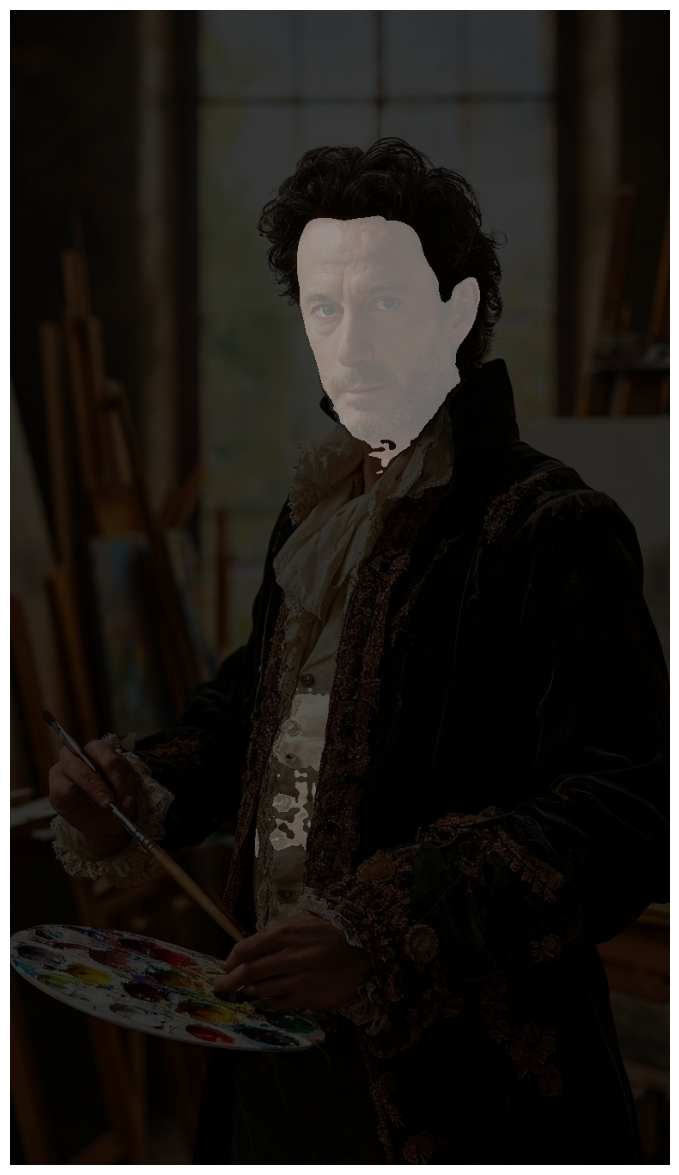

In [2]:
import numpy as np
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

class FaceDetectorSAM:
   def __init__(self, checkpoint_path: str, model_type: str = "vit_h", device: str = "cuda"):
       self.device = torch.device(device if torch.cuda.is_available() and device == "cuda" else "cpu")
       print(f"Using device: {self.device}")
       
       # SAM 모델 초기화
       self.sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
       self.sam.to(device=self.device)
       self.predictor = SamPredictor(self.sam)
       
       # OpenCV 얼굴 검출기 초기화
       self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
       
   def detect_faces(self, image: np.ndarray):
       # OpenCV로 얼굴 위치 검출
       gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
       faces = self.face_cascade.detectMultiScale(
           gray,
           scaleFactor=1.1,
           minNeighbors=5,
           minSize=(30, 30)
       )
       
       if len(faces) == 0:
           print("No faces detected by OpenCV")
           return []
       
       # RGB 변환 및 SAM 이미지 설정
       rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
       self.predictor.set_image(rgb_image)
       
       face_masks = []
       for (x, y, w, h) in faces:
           # 얼굴 영역만 정확하게 지정하기 위해 패딩값 조정
           padding = int(min(w, h) * 0.1)  # 패딩 값을 0.2에서 0.1로 줄임
           x1 = max(0, x - padding)
           y1 = max(0, y - padding)
           x2 = min(image.shape[1], x + w + padding)
           y2 = min(image.shape[0], y + h + padding)
           
           # 얼굴 중심점 계산
           center_point = np.array([[(x + w//2), (y + h//2)]])
           
           # SAM으로 마스크 생성
           masks, scores, _ = self.predictor.predict(
               point_coords=center_point,
               point_labels=np.array([1]),
               multimask_output=True,
               box=np.array([x1, y1, x2, y2])
           )
           
           # 가장 작은 마스크 선택
           if len(masks) > 0:
               mask_sizes = [np.sum(mask) for mask in masks]
               best_mask_idx = np.argmin(mask_sizes)  # argmax 대신 argmin 사용
               
               # 마스크 크기가 너무 크면 제외 (이미지 크기의 15% 이상인 경우)
               mask_area = mask_sizes[best_mask_idx]
               total_area = image.shape[0] * image.shape[1]
               if mask_area < (total_area * 0.15):
                   face_masks.append(masks[best_mask_idx])
               else:
                   print(f"Mask too large: {mask_area/total_area:.2%} of image")
       
       return face_masks

   def visualize_detections(self, image: np.ndarray, masks: list, save_path: str = None):
       plt.figure(figsize=(15, 15))
       plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
       
       # 마스크 시각화 (흰색/검은색)
       for mask in masks:
           color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
           color_mask[mask] = [255, 255, 255]  # 흰색
           plt.imshow(color_mask, alpha=0.4)
       
       plt.axis('off')
       if save_path:
           plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=300)
       plt.show()
       
       # OpenCV로 사각형 표시
       image_with_rect = image.copy()
       gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
       faces = self.face_cascade.detectMultiScale(
           gray,
           scaleFactor=1.1,
           minNeighbors=5,
           minSize=(30, 30)
       )
       
       for (x, y, w, h) in faces:
           cv2.rectangle(image_with_rect, (x, y), (x+w, y+h), (0, 255, 0), 2)
       
       if save_path:
           rect_save_path = save_path.rsplit('.', 1)[0] + '_rect.jpg'
           cv2.imwrite(rect_save_path, image_with_rect)

# 사용하기
CHECKPOINT_PATH = "model/sam_vit_h_4b8939.pth"
detector = FaceDetectorSAM(CHECKPOINT_PATH)

# 이미지 로드
image_path = "input_image/painter.jpeg"
image = cv2.imread(image_path)
if image is None:
   raise ValueError(f"Could not load image from {image_path}")

# 얼굴 감지
face_masks = detector.detect_faces(image)
print(f"Detected {len(face_masks)} faces")

# 결과 시각화 및 저장
detector.visualize_detections(image, face_masks, "output_face_detection.jpg")